In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Lattice Boltzman Adveccion Difusion

In [206]:
%%cython 
import numpy as np
cimport numpy as np
from libc.math cimport exp, sqrt, pow, M_PI
from libc.stdio cimport FILE, fopen, fclose, fprintf
from libc.stdlib cimport malloc, free

# Velocidad del lattice y velocidad del sonido
cdef double C = 1.0  # Velocidad característica del lattice
cdef double Cs = C / sqrt(3)  # Velocidad de la onda sonora
cdef double Cs2 = Cs * Cs  # Velocidad de la onda sonora al cuadrado

#-------------------------------VARIABLES GLOBALES------------------------

# Parámetros de difusión y relajación
cdef double D = 0.016  # Coeficiente de difusión
cdef double tau = (D / Cs2) + 0.5;  # Tiempo de relajación
cdef double Utau = 1.0 / tau  # Inverso del tiempo de relajación
cdef double UmUtau = 1 - Utau # 1 - 1/tau

#-------------------------------CLASES--------------------------------------
cdef class LatticeBoltzman:
    cdef int Lx, Ly, t_hour, iter_per_hour, Q
    cdef double* w
    cdef int index_f 
    cdef bint IsData
    cdef int* Vx, 
    cdef int *Vy, 
    
    
    cdef double* f
    cdef double* fnew
    
    # Usamos `object` aquí en lugar de `np.ndarray` para evitar el error de buffer
    cdef object id
    cdef object rho_f
    cdef object Ux  
    cdef object Uy  
    
    def __cinit__(self, int Lx, int Ly, int t_hour, 
                  int iter_per_hour, 
                  np.ndarray[np.int_t, ndim=1] id,
                  np.ndarray[np.double_t, ndim=1] rho_f,
                  np.ndarray[np.double_t, ndim=1] Ux, 
                  np.ndarray[np.double_t, ndim=1] Uy):
        
        self.Lx = Lx
        self.Ly = Ly
        self.t_hour = t_hour
        self.iter_per_hour = iter_per_hour
        self.index_f = 0
        self.IsData = True
        
        self.Q = 9
        self.w = <double*> malloc(self.Q * sizeof(double))
        self.Vx = <int*> malloc(self.Q * sizeof(int))
        self.Vy = <int*> malloc(self.Q * sizeof(int))
        
        self.Ux = Ux
        self.Uy = Uy
        self.id = id
        self.rho_f = rho

        # Asignación de los pesos y vectores de velocidad
        self.w[0] = 4.0 / 9
        for i in range(1, 5):
            self.w[i] = 1.0 / 9
        for i in range(5, 9):
            self.w[i] = 1.0 / 36

        self.Vx[8] = 1
        self.Vx[1] = 1
        self.Vx[5] = 1
        self.Vx[4] = 0
        self.Vx[0] = 0
        self.Vx[2] = 0
        self.Vx[7] = -1
        self.Vx[3] = -1
        self.Vx[6] = -1

        self.Vy[8] = -1
        self.Vy[1] = 0
        self.Vy[5] = 1
        self.Vy[4] = -1
        self.Vy[0] = 0
        self.Vy[2] = 1
        self.Vy[7] = -1
        self.Vy[3] = 0
        self.Vy[6] = 1

        cdef int ArraySize = self.Lx * self.Ly * self.Q
        self.f = <double *> malloc(ArraySize * sizeof(double))
        self.fnew = <double *> malloc(ArraySize * sizeof(double))

    def __dealloc__(self):
        free(self.f)
        free(self.fnew)
        free(self.w)
        free(self.Vx)
        free(self.Vy)

    cdef int n(self, int ix, int iy, int i):
        return (ix * self.Ly + iy) * self.Q + i

    cdef double rho(self, int ix, int iy, bint UseNew):
        cdef double sum = 0.0
        cdef int i, n0
        for i in range(self.Q):
            n0 = self.n(ix, iy, i)
            if UseNew:
                sum += self.fnew[n0]
            else:
                sum += self.f[n0]
        return sum

    cdef double Jx(self, int ix, int iy, bint UseNew):
        cdef double sum = 0.0
        cdef int i, n0
        for i in range(self.Q):
            n0 = self.n(ix, iy, i)
            if UseNew:
                sum += self.Vx[i] * self.fnew[n0]
            else:
                sum += self.Vx[i] * self.f[n0]
        return sum

    cdef double Jy(self, int ix, int iy, bint UseNew):
        cdef double sum = 0.0
        cdef int i, n0
        for i in range(self.Q):
            n0 = self.n(ix, iy, i)
            if UseNew:
                sum += self.Vy[i] * self.fnew[n0]
            else:
                sum += self.Vy[i] * self.f[n0]
        return sum

    cdef double feq(self, double rho0, double Ux0, double Uy0, int i):
        cdef double UdotVi = Ux0 * self.Vx[i] + Uy0 * self.Vy[i]
        cdef double U2 = Ux0 * Ux0 + Uy0 * Uy0
        return rho0 * self.w[i] * (1 + UdotVi / Cs2 + (UdotVi * UdotVi) / (2.0 * Cs2 * Cs2) - U2 / (2.0 * Cs2))

    cpdef Start(self, double rho0, double Ux0, double Uy0):
        cdef int ix, iy, i, n0
        cdef double rho = rho0
        for ix in range(self.Lx):
            for iy in range(self.Ly):
                for i in range(self.Q):
                    n0 = self.n(ix, iy, i)
                    self.f[n0] = self.feq(rho, Ux0, Uy0, i)

    cpdef Collision(self):
        cdef int ix, iy, i, n0
        cdef double rho0, Ux0, Uy0
        for ix in range(self.Lx):
            for iy in range(self.Ly):
                rho0 = self.rho(ix, iy, False)
                Ux0 = self.Jx(ix, iy, False) / rho0
                Uy0 = self.Jy(ix, iy, False) / rho0
                for i in range(self.Q):
                    n0 = self.n(ix, iy, i)
                    self.fnew[n0] = UmUtau * self.f[n0] + Utau * self.feq(rho0, Ux0, Uy0, i)

    cpdef ImposeFields(self, int t):
        cdef int ix, iy, i, index
        cdef int auxT = t // self.iter_per_hour
        cdef double rho0, Ux0, Uy0
        cdef int index_tmp = 0

        for ix in range(self.Lx):
            for iy in range(self.Ly):
                index = ix * self.Ly + iy + self.Lx * self.Ly * auxT
                Ux0 = self.Ux[index]
                Uy0 = self.Uy[index]
                rho0 = self.rho(ix, iy, True)

                for i in range(self.Q):
                    n0 = self.n(ix, iy, i)
                    
                    if ((ix * self.Ly) + iy) == self.id[self.index_f] and self.IsData:
                        self.fnew[n0] = self.feq(self.rho_f[self.index_f], Ux0, Uy0, i)

                        if i == self.Q - 1:
                            self.index_f += 1
                            index_tmp += 1
                        if (t + 1) % (self.iter_per_hour * 24) != 0:
                            self.index_f -= index_tmp
                        if self.index_f >= len(self.id):
                            self.IsData = False
                    else:
                        self.fnew[n0] = self.feq(rho0, Ux0, Uy0, i)

    cpdef Advection(self):
        cdef int ix, iy, i, ixnext, iynext, n0, n0next
        for ix in range(self.Lx):
            for iy in range(self.Ly):
                for i in range(self.Q):
                    ixnext = ix + self.Vx[i]
                    iynext = iy + self.Vy[i]
                    if 0 <= ixnext < self.Lx and 0 <= iynext < self.Ly:
                        n0 = self.n(ix, iy, i)
                        n0next = self.n(ixnext, iynext, i)
                        self.f[n0next] = self.fnew[n0]

    cpdef np.ndarray[np.double_t, ndim=2] Data(self):
        # Crear un array de NumPy para almacenar los resultados
        cdef np.ndarray[np.double_t, ndim=2] result = np.zeros((self.Lx, self.Ly), dtype=np.double)
        cdef double rho0
        cdef int ix, iy
        cdef int step = 1
        
        # Rellenar el array de resultados
        for ix in range(0, self.Lx, step):
            for iy in range(0, self.Ly, step):
                rho0 = self.rho(ix, iy, False)
                result[ix, iy] = rho0  # Asignar valores al array NumPy

        return result


Content of stdout:
_cython_magic_da39b9e81d462b54c4683d42fce8cd45fab67d4c.c
c:\Users\cterr\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
   Creando biblioteca C:\Users\cterr\.ipython\cython\Users\cterr\.ipython\cython\_cython_magic_da39b9e81d462b54c4683d42fce8cd45fab67d4c.cp311-win_amd64.lib y objeto C:\Users\cterr\.ipython\cython\Users\cterr\.ipython\cython\_cython_magic_da39b9e81d462b54c4683d42fce8cd45fab67d4c.cp311-win_amd64.exp
Generando código
Generación de código finalizada

## Simulacion

In [207]:
#-------------------------------SIMULACIÓN--------------------------------------
def simulation(Lx, Ly, t_hour,  t_inital, t_final, iter_per_hour, Ux, Uy, id, rho_f):
    rho0 = 0.001
    Ux0 = 0.0
    Uy0 = 0.0

    lbm = LatticeBoltzman(Lx, Ly, t_hour, iter_per_hour, id, rho_f, Ux, Uy)
    lbm.Start(rho0, Ux0, Uy0)

    # Simular por 100 pasos de tiempo
    for t in range(t_inital, t_final):
        lbm.Collision()
        lbm.ImposeFields(t)
        lbm.Advection()
        
    return  lbm.Data()
            
            

## Carga de Datos

In [ ]:
#-------------------------------Carga de datos--------------------------------------

# Cargar datos de velocidad
data = np.loadtxt('data/velocity.txt')
Ux = data[:, 0]
Uy = data[:, 1]

# Cargar datos de densidad de incendios
data = np.loadtxt('data/fire_coord.txt')
id = data[:, 0].astype(int)
rho_f = data[:, 1]

#Parámetros de la simulación
data = np.loadtxt('data/parameters.txt')
Lx = int(data[0])
Ly = int(data[1])

#Coordenadas estaciones
data = np.loadtxt('data/stations_coord.txt')
Est = data[:, 0].astype(str)
Est_ix = data[:, 1].astype(int)
Est_iy = data[:, 2].astype(int)


In [195]:
#-------------------------------MAIN--------------------------------------
# Lx = 100
# Ly = int(Lx*1.4)
t_hour = 10
iter_per_hour = 10
t_inital = 10
t_final = t_hour*iter_per_hour
# Ux = np.zeros((Lx*Ly*t_hour))
# Uy = np.zeros((Lx*Ly*t_hour))

size = 10

# id = np.zeros((size))
# rho_f = np.zeros((size))


# Ejecutar la simulación
result_simulation = simulation(Lx, Ly, t_hour, t_inital, t_final, iter_per_hour, Ux, Uy, id, rho_f)
result_simulation.shape

(100, 140)

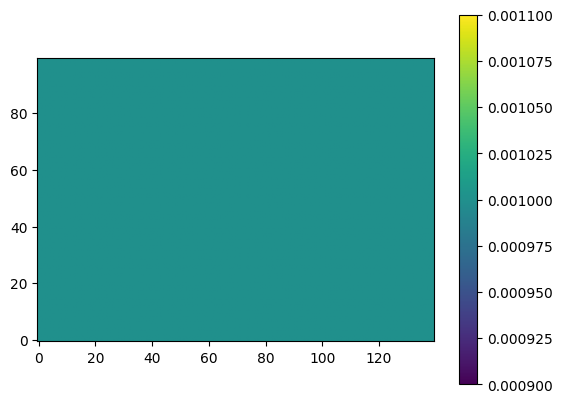

In [198]:
# Graficar los resultados
plt.imshow(result_simulation, cmap='viridis', origin='lower')
plt.colorbar(cax=None, ax=None, orientation='vertical')
plt.savefig(f'/frames/frame_{t_final}.png')

In [ ]:
# Extraer los valores de result_simulation en base a las coordenadas de las estaciones
station_values = result_simulation[Est_ix, Est_iy]

# Mostrar los valores extraídos
for est, ix, iy, value in zip(Est, Est_ix, Est_iy, station_values):
    print(f"Estación: {est}, ix: {ix}, iy: {iy}, Valor: {value}")

# Ajuste 